# Parametrized test posteriors

## Setup

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
import sys
import warnings
import seaborn as sns
import pandas as pd
from matplotlib.patches import Patch
import matplotlib.ticker as ticker
import numpy
import subprocess

In [3]:
sys.path.append('../../')

import utils
from par_plotter import *


sns.set(style='ticks', context='notebook', font='serif', 
        font_scale=1.5, palette='colorblind')
plt.rcParams.update(utils.rcParams)
plt.rcParams['font.family'] = 'times-new-roman'


# further tune some rcParams
plt.rcParams.update({
    'ytick.labelsize': 0.8*utils.fs_label,
    'legend.fontsize': 0.8*utils.fs_label,
})

# silence PerformanceWarnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

numpy.random.seed(1234)

## Settings

In [4]:
approxs = ['seob']
cache_path = '../combined/posterior_{kind}_{approx}_{param}_gwtc-3.dat.gz'

In [5]:
pre_params = ['dphi-2']+ ['dphi%i' % n for n in range(5)] +\
             ['dphi5l', 'dphi6', 'dphi6l', 'dphi7']
params = pre_params

In [6]:
def load_data(kind):
    ''' Load combined data of given kind ('simple' or 'hierarchical').
    '''
    if kind == 'simple':
        kind = 'combined'
    df = pd.DataFrame(columns=['param', 'value', 'approx'])
    for a in approxs:
        for p in params:
            path = cache_path.format(param=p, approx=a, kind=kind)
            if os.path.isfile(path):
                samples = np.loadtxt(path)
                df = df.append(
                    pd.DataFrame({
                        'value': samples,
                        'approx': [a]*len(samples),
                        'param': [p]*len(samples),
                    }), ignore_index=True, sort=False)
    return df

## Violin plot

Load posterior data.

In [7]:
df_simple = load_data('simple')

In [8]:
df_hier = load_data('hierarchical')

In [9]:
df_simple

param     value approx
0      dphi-2  0.000100   seob
1      dphi-2  0.000901   seob
2      dphi-2 -0.000100   seob
3      dphi-2 -0.000300   seob
4      dphi-2  0.000300   seob
...       ...       ...    ...
49995   dphi7  1.186186   seob
49996   dphi7  0.765766   seob
49997   dphi7  0.915916   seob
49998   dphi7  0.795796   seob
49999   dphi7 -0.165165   seob

[50000 rows x 3 columns]

Plot all violins.

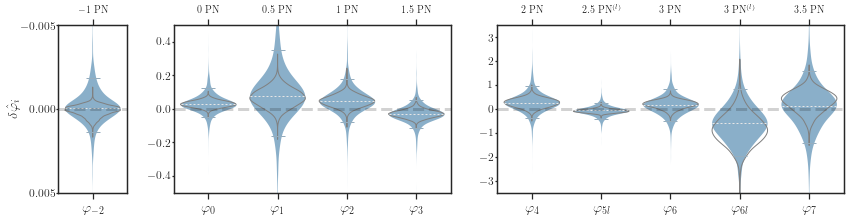

In [10]:
palette = [sns.color_palette('Set3')[i] for i in [4]]

kwargs = {'bw':0.3}

fig = plot_violin(df_hier, palette=palette, nolegend=True, **kwargs,singles=pre_params, inspiral_only=True)
for pars, ax in zip(DEF_BREAK, fig.axes):
    for c in ax.collections:
        c.set_linewidth(0)
        
fig = plot_violin(df_simple, fig=fig, palette=['w'], inner=None, 
                  nolegend=True, mark_ci=False, top_ticks=True, **kwargs,singles=pre_params, inspiral_only=True)
for pars, ax in zip(DEF_BREAK, fig.axes):
    for c in ax.collections:
        if all([i==1 for i in c.get_facecolor()]):
            c.set_edgecolor('gray')
            c.set_facecolor('None')
            c.set_linewidth(1)

# set custom y-limits for each subplot
ymaxs = [0.01, 0.5, 3.5, -0.005]
for ymax, ax in zip(ymaxs, fig.axes):
    ax.set_ylim(-ymax, ymax)
    if  ymax == 1:
        ax.set_yticks([-1, -0.5, 0, 0.5, 1])
    if  ymax == 0.01:
        ax.set_yticks([-0.01, -0.005, 0, 0.005, 0.01])

fig.savefig('./par_violin_seob.pdf', bbox_inches='tight')
plt.show(fig)

## Table

Get population hyperparameters.

In [11]:
rescale_minus2 = 200

In [12]:
# path to hierarchical hyperparameter results
cache_path = '../hyperparams/hyper_{approx}_{par}_{hyper}.dat.gz'

hyper_dict = {}
for a in approxs:
    draws = {}
    for k in ['mu', 'sigma']:
        draws[k] = {}
        for p in params:
            path = cache_path.format(par=p, hyper=k, approx=a)
            if os.path.exists(path):
                draws[k][p] = np.loadtxt(path)
    hyper_dict[a] = draws

Construct table `DataFrame`.

In [13]:
# formatter for 90%-credible intervals
def get_interval_string(x, template=None):
    template = template or r'$%.2f^{+%.2f}_{-%.2f}$'
    med = np.median(x)
    lo, hi = np.percentile(x, 10), np.percentile(x, 90)
    return template % (med, hi-med, med-lo)

In [14]:
dfs_dict = {'simple': df_simple, 'hier': df_hier}

rows = []
for a in approxs:
    for p in df_hier[df_hier['approx']==a]['param'].unique():
        row = {}
        # summarize hyperparameters
        if '-2' in p and rescale_minus2:
            scale = rescale_minus2
        else:
            scale = 1
        row['mu'] = get_interval_string(scale*hyper_dict[a]['mu'][p])
        row['sigma'] = r'$<%.2f$' % np.percentile(scale*hyper_dict[a]['sigma'][p], 90)
        # summarize simple and hier pops
        for k, df in dfs_dict.items():
            x = scale*df.loc[(df['approx']==a) & (df['param']==p)]['value']
            row['value_%s' % k] = get_interval_string(x)
            q_hier = utils.get_quantile_from_samples(x)
            row['Q_%s' % k] = r'${}\%$'.format(int(q_hier*100))
        # add row to list (indexed by parameter and waveform)
        index = pd.MultiIndex.from_tuples([(get_label(p), a[0].upper())],
                         names=['param', 'WF'])
        rows.append(pd.DataFrame(row, index=index))

In [15]:
df_table = pd.concat(rows)

# sort index
df_table = df_table.loc[[(get_label(p), a[0].upper()) for p in params_pre for a in approxs]]

# rename columns
c = [k.split('_')[0] for k in df_table.columns]
z = df_table.columns.map(lambda x: 'simple' if 'simple' in x else 'hyper')
df_table.columns = pd.MultiIndex.from_tuples(zip(z, c), names=['kind', 'stat'])

# sort columns
df_table = df_table[[('hyper', k) for k in ['mu', 'sigma', 'value', 'Q']] + \
                    [('simple', k) for k in ['value', 'Q']]]

df_table

kind                                   hyper           \
stat                                      mu    sigma   
param            WF                                     
${\varphi}_{-2}$ S   $-0.02^{+0.11}_{-0.13}$  $<0.29$   
${\varphi}_{0}$  S    $0.03^{+0.03}_{-0.03}$  $<0.08$   
${\varphi}_{1}$  S    $0.07^{+0.09}_{-0.08}$  $<0.23$   
${\varphi}_{2}$  S    $0.05^{+0.05}_{-0.05}$  $<0.12$   
${\varphi}_{3}$  S   $-0.03^{+0.03}_{-0.03}$  $<0.08$   
${\varphi}_{4}$  S    $0.26^{+0.26}_{-0.23}$  $<0.62$   
${\varphi}_{5l}$ S   $-0.07^{+0.11}_{-0.11}$  $<0.30$   
${\varphi}_{6}$  S    $0.17^{+0.21}_{-0.23}$  $<0.59$   
${\varphi}_{6l}$ S   $-0.61^{+0.68}_{-0.69}$  $<1.20$   
${\varphi}_{7}$  S    $0.10^{+0.49}_{-0.53}$  $<1.33$   

kind                                                                   simple  \
stat                                   value       Q                    value   
param            WF                                                             
${\varphi}_{-2}$ S   $-0.01^{+0.20}_{-0.25}$  $53\%$   $0.02^{+0.08}_{-0.08}$   
${\varphi}_{0}$  S    $0.03^{+0.07}_{-0.05}$  $21\%$   $0.03^{+0.03}_{-0.02}$   
${\varphi}_{1}$  S    $0.08^{+0.19}_{-0.16}$  $24\%$   $0.07^{+0.07}_{-0.07}$   
${\varphi}_{2}$  S    $0.05^{+0.09}_{-0.09}$  $20\%$   $0.04^{+0.05}_{-0.04}$   
${\varphi}_{3}$  S   $-0.03^{+0.06}_{-0.06}$  $77\%$  $-0.03^{+0.02}_{-0.02}$   
${\varphi}_{4}$  S    $0.26^{+0.47}_{-0.44}$  $19\%$   $0.26^{+0.21}_{-0.24}$   
${\varphi}_{5l}$ S   $-0.07^{+0.23}_{-0.23}$  $69\%$  $-0.11^{+0.12}_{-0.09}$   
${\varphi}_{6}$  S    $0.16^{+0.44}_{-0.49}$  $31\%$   $0.20^{+0.18}_{-0.24}$   
${\varphi}_{6l}$ S   $-0.61^{+1.05}_{-1.02}$  $79\%$  $-0.89^{+0.81}_{-0.78}$   
${\varphi}_{7}$  S    $0.14^{+1.05}_{-1.16}$  $42\%$   $0.35^{+0.48}_{-0.60}$   

kind                         
stat                      Q  
param            WF          
${\varphi}_{-2}$ S   $39\%$  
${\varphi}_{0}$  S    $6\%$  
${\varphi}_{1}$  S   $10\%$  
${\varphi}_{2}$  S    $7\%$  
${\varphi}_{3}$  S   $90\%$  
${\varphi}_{4}$  S    $8\%$  
${\varphi}_{5l}$ S   $89\%$  
${\varphi}_{6}$  S   $14\%$  
${\varphi}_{6l}$ S   $91\%$  
${\varphi}_{7}$  S   $22\%$

In [16]:
# insert buffer columns
j = 0
for i in [0, 4]:
    df_table.insert(i + j, (r'\phantom{X}', r'\phantom{X}'), ' ', allow_duplicates=True)
    j += 1

Write out LaTex file.

In [17]:
# write_latex
latex = df_table.to_latex(escape=False, float_format='%.2f',
                          column_format='crrrrrrrr')

# manually rename some columns
substitutions = {
    ' stat ': '   ',
    ' mu ': r' $\mu$ ',
    ' sigma ': r' $\sigma$ ',
    ' value ': r' $\delta\hat{\varphi}_i$ ',
    ' Q ': r' $Q_{\rm GR}$ ',
    'param': '',
    'kind': '',
    r'{l}': r'{c}',
    'simple': 'Restricted',
    'hyper': 'General',
}

for k,v in substitutions.items():
    latex = latex.replace(k, v)

# move "WF" label one row up
lines = [l for l in latex.splitlines() if 'WF' not in l]
lines[2] = lines[2].replace(r' &  & \phantom{X}', r'${\varphi}_i$ & \phantom{X}')
lines.insert(3, r'\cline{3-6} \cline{8-9}')

# insert space to separate inspiral parameters
new_lines = []
add_minus2_rescale = True
for l in lines:
    add_minus2_rescale = r'{-2}' in l and rescale_minus2
    if 'S' in l or any([k in l for k in ['alpha', 'beta']]):
        l += '[4pt]'
        l = l.replace('& S &','&')
    if add_minus2_rescale:
        l = l.replace(r'{-2}', r'{-2}^{[\times %i]}' % rescale_minus2)
    new_lines.append(l)
    

# new_lines = lines
new_lines.insert(len(new_lines)-(len(params_post)+2), '\midrule')

In [18]:
# center headers
chars={'\\mu','\\sigma','\\delta\\hat{\\varphi}_i'}
for char in chars:
    new_lines[4]=new_lines[4].replace('$'+char+'$','\\multicolumn{1}{c}{$'+char+'$}')

In [19]:
# get rid of extra space (only SEOB)
new_lines[4]=new_lines[4].replace('&   & \\phantom{X} &','&   &')

In [20]:
latex = '\n'.join(new_lines)
with open('./tab_par.tex', 'w') as f:
    f.write(latex)

## Quantile plots

First, compute the GR z-score based on the samples from the hierarchical analysis.

In [21]:
rows = []
for a in approxs:
    for p in df_hier[df_hier['approx']==a]['param'].unique():
        row = {}
        # summarize hyperparameters
        q = utils.get_2d_quantile_from_samples(hyper_dict[a]['mu'][p], hyper_dict[a]['sigma'][p])
        rows.append({'Q': q, 'WF': a[0].upper(), 'param': p})
df_mu_sigma = pd.DataFrame(rows)

Now, make a plot summarizing all scale-invariant figures of merit.

In [22]:
from scipy.stats import norm

In [23]:
df = df_mu_sigma[df_mu_sigma['WF']=='S']
df.set_index('param', inplace=True)
x = df['Q'] * 100

In [24]:
get_quantity = {
    'Q': lambda x: float(x[1:3].replace('\\','')),
    'mu': lambda x: float(x.split('^')[0].strip('$')),
    'sigma': lambda x: float(x[2:5]),
}

def get_quantity_from_table(key, kind, wf):
    return df_table[(kind, key)].unstack(0).loc[wf[0].upper()].dropna().map(get_quantity[key])

In [25]:
def plot_strip(k, ax=None, kind='hyper'):
    if ax is None:
        fig, ax = plt.subplots(1, figsize=(utils.fig_width, 0.15*utils.fig_height))
    for c, wf in zip(palette, approxs):
        # recover quantity from LaTex table
        if k.lower() == 'z':
            # compute z-score
            # first, get GR quantile as decimal (not percent)
            q = get_quantity_from_table('Q', kind, wf) / 100
            
            # the z-score (here called `x`, because it'll be plotted on the x
            # axis) is simply the inverse CDF of the GR quantile, under the 
            # assumption of a normal distribution
            x = q.apply(norm.ppf)
            
        elif k == 'Q2D' and kind == 'hyper':
            df = df_mu_sigma[df_mu_sigma['WF']==wf[0].upper()]
            df.set_index('param', inplace=True)
            x = df['Q'] * 100
        else:
            x = get_quantity_from_table(k, kind, wf) * 100
        target = 50 if k == 'Q' else 0
        y = np.abs(x.values - target)
        x = x.values
        best = (z[y.argmin()], y.min()) if any(y) else None
        # plot all coefficients
        ax.plot(x, np.ones(len(x)), ls='none', marker='|', ms=25, mew=3, c=c, alpha=0.7)
    return ax, best

5.276048152760482 0.42355039981741777


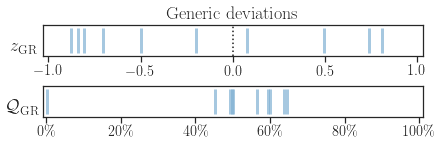

In [26]:
fig, axs = plt.subplots(2, 1, figsize=(utils.fig_width, 0.1*utils.fig_height*4))
fig.subplots_adjust(hspace=1)

grkws = {
    'ls': 'none',
    'marker': '*',
    'ms': 15,
    'markerfacecolor': '0.5',
    'markeredgecolor': 'w',
    'mew': 0,
    'alpha': 1,
}

best_ab = {}

# Hyper z-score
ax, best_ab['Zh'] = plot_strip('z', axs[0])
ax.axvline(0, c='k', ls=':')
ax.set_xlim(-1.03, 1.03)
ax.set_ylabel(r'$z_{\rm GR}$', rotation=0);
ax.yaxis.set_label_coords(-0.05, 0.05)

# GR quantile
ax, best_ab['Qh'] = plot_strip('Q2D', axs[-1])
ax.set_xlim(-0.89, 100.89)

ax.set_ylabel(r'$\mathcal{Q}_{\rm GR}$', rotation=0);
ax.yaxis.set_label_coords(-0.05, 0.05)

labels = [r'$%.0f\%%$' % l for l in ax.get_xticks()]
ax.xaxis.set_major_locator(ticker.FixedLocator(ax.get_xticks()))
ax.xaxis.set_major_formatter(ticker.FixedFormatter(labels))

axs[0].set_title('Generic deviations')
for ax in axs:
    ax.set_yticks([]);

# check axis size
bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
print(bbox.width, bbox.height)

fig.savefig('par_summary_hier.pdf', bbox_inches='tight')

5.276048152760482 0.423550399817418


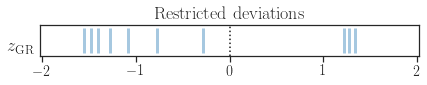

In [27]:
fig, ax = plt.subplots(1, figsize=(utils.fig_width, 0.1*utils.fig_height*4/3))
fig.subplots_adjust(hspace=1)

# Hyper z-score
ax, best_ab['Zs'] = plot_strip('z', kind='simple', ax=ax)
ax.axvline(0, c='k', ls=':')
ax.set_xlim(-2.03, 2.03)
ax.set_ylabel(r'$z_{\rm GR}$', rotation=0);
ax.yaxis.set_label_coords(-0.05, 0.05)

ax.set_title('Restricted deviations')
ax.set_yticks([]);

bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
print(bbox.width, bbox.height)

fig.savefig('par_summary_simple.pdf', bbox_inches='tight')

In [28]:
best_ab

{'Zh': ('hyper', 0.0752698620998299),
 'Qh': ('hyper', 0.17500000000000002),
 'Zs': ('hyper', 0.27931903444745415)}

## Macros

In [29]:
def make_macro(l, v, k, wf='S', kind='hier', name='', Q=None):
    if kind == 'hyper': kind = 'hier'
    cases = ''.join([
        r'{NAME}{\ensuremath{\delta\hat%s}}' % (l.replace('$', '')),
        r'{VALUE}{\ensuremath{%s}}' % (v.replace('$', ''))])
    if Q is not None:
        cases += r'{QGR}{%s}' % Q.strip('$')
    m = r'\newcommand{\Par%s}[1]{\IfEqCase{#1}{%s}}' % \
        (k.capitalize() + kind.capitalize() + name.capitalize() + wf, cases)
    return m

macros = []
for kind, df in dfs_dict.items():
    # should rename hyper -> hier above to simplify this...
    kind = kind if 's' in kind else 'hyper'
    for approx in approxs:
        wf = approx[0].upper()
        # find best and worst constrained parameters
        stds = df.loc[df['approx']==approx].groupby('param', sort=False).std()
        for k, p in zip(['Best', 'Worst'], [stds.idxmin(), stds.idxmax()]):
            # get interval
            l = get_label(p.value)
            x = df.loc[(df['approx']==approx) & (df['param']==p.value)]['value']
            if '-2' in l:
                t = r'$%.2f^{+%.2f}_{-%.2f}\times 10^{-3}$'
                scale = 1E3
            else:
                t, scale = None, 1
            v = get_interval_string(x*scale, t)
            # get GR quantile
            q = df_table[(kind, 'Q')].unstack(0).loc[wf].unstack()[l].iloc[0]
            macros.append(make_macro(l, v, k, wf, kind, 'Pop', Q=q))
        # find best and worst Z score
        if 's' not in kind:
            # get z-score absolute values
            zs = (get_quantity_from_table('Q', kind, wf)/100).apply(norm.ppf).abs()
            # best
            l = zs.index[zs.argmin()][-1]
            v = '%.2f' % zs.min()
            macros.append(make_macro(l, v, 'Best', wf, kind, 'Zgr'))
            # worst
            l = zs.index[zs.argmax()][-1]
            v = '%.2f' % zs.max()
            macros.append(make_macro(l, v, 'Worst', wf, kind, 'Zgr'))
            

cases = [r'{%s_NAME}{\ensuremath{\delta\hat%s}}{%s_VALUE}{%.1f}' %
         (k, v[0].strip('$'), k, v[1]) for k,v in best_ab.items()]
macros.append(r'\newcommand{\ParAlphaBetaBest}[1]{\IfEqCase{#1}{%s}}' % ''.join(cases))

with open('./par_macros.tex', 'w') as f:
    f.write('\n'.join(macros))